In [1]:
import sys
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.
C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 9s 1us/step


In [4]:
print('Training data and labels: {} {}'.format(x_train.shape, y_train.shape))
print('Testing data and labels: {} {}'.format(x_test.shape, y_test.shape))

Training data and labels: (60000, 28, 28) (60000,)
Testing data and labels: (10000, 28, 28) (10000,)


In [5]:
%matplotlib inline

C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


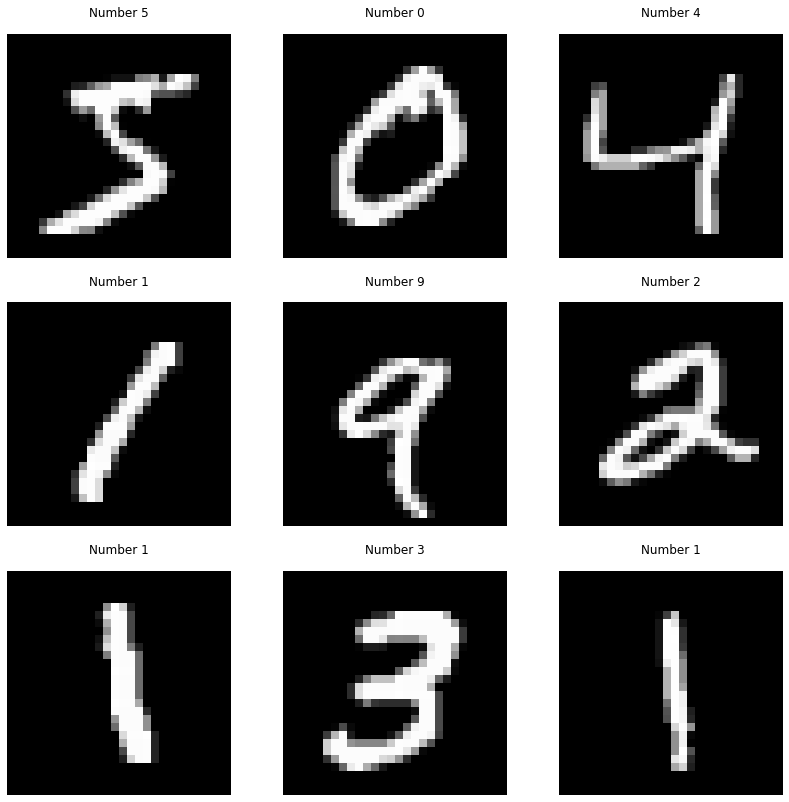

In [7]:
# Displaying images
fig, axs = plt.subplots(3, 3, figsize = (14, 14))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
fig.show()

In [8]:
# Preprocessing images: Reshaping to 1D and normalizing
X_train = x_train.reshape(len(x_train), -1)
Y_train = y_train

X_test = x_test.reshape(len(x_test), -1)
Y_test = y_test

X_train = X_train.astype('float') / 255.0
X_test = X_test.astype('float') / 255.0

print('Shape: {}'.format(X_train.shape))

Shape: (60000, 784)


In [39]:
# Training the model
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(Y_train))

kmeans = MiniBatchKMeans(n_clusters = n_digits)

kmeans.fit(X_train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [40]:
kmeans.labels_[:20] # These are not actual results, merely the clusters which the points belong to.

array([0, 6, 9, 2, 9, 8, 2, 1, 2, 9, 3, 2, 3, 7, 2, 5, 8, 1, 7, 2])

In [52]:
# Functions to determine which cluster belongs to which labels
def infer_class_labels(kmeans, actual_labels):
    
    inferred_labels = {}
    
    for i in range(kmeans.n_clusters):
        
        # Get all points belonging to a particular cluster
        indices = np.where(kmeans.labels_ == i)
        labels = actual_labels[indices]
        
        # Determining most common label and adding it to corresponding label in dictionary
        if len(labels) == 1:
            counts = np.bincount(labels)
        else:
            counts = np.bincount(np.squeeze(labels))
        
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
            
        # print('Labels: {}'.format(labels))
        # print('Cluster {} with label {}'.format(i, np.argmax(counts)))
            
    return inferred_labels

# Get the actual labels predicted by model
def infer_data_labels(X_labels, cluster_labels):
    
    predicted = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, val in cluster_labels.items():
            if cluster in val:
                predicted[i] = key
    
    return predicted

In [48]:
# Obtaining actual labels
cluster_labels = infer_class_labels(kmeans, Y_train)
predicted_clusters = kmeans.predict(X_train)
predictions = infer_data_labels(predicted_clusters, cluster_labels)

print(Y_train[:20])
print(predictions[:20])

Labels: [5 8 3 ... 3 3 5]
Cluster 0 with label 8
Labels: [3 8 9 ... 8 8 8]
Cluster 1 with label 8
Labels: [1 1 1 ... 1 5 1]
Cluster 2 with label 1
Labels: [3 3 3 ... 3 3 3]
Cluster 3 with label 3
Labels: [0 0 0 ... 0 0 0]
Cluster 4 with label 0
Labels: [7 2 9 ... 7 9 9]
Cluster 5 with label 7
Labels: [0 0 0 ... 0 6 0]
Cluster 6 with label 0
Labels: [6 6 6 ... 6 6 6]
Cluster 7 with label 6
Labels: [2 2 2 ... 2 2 2]
Cluster 8 with label 2
Labels: [4 9 4 ... 9 4 4]
Cluster 9 with label 4
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[8 0 4 1 4 2 1 8 1 4 3 1 3 6 1 7 2 8 6 1]


In [53]:
# Optimising and evaluating the model
from sklearn.metrics import homogeneity_score, accuracy_score

def calc_metrics(estimator, data, labels):
    
    print('\nClusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(homogeneity_score(labels, estimator.labels_)))

### Metrics for training data

In [54]:
# Optimising model for different number of clusters
clusters = [10, 16, 32, 64, 128, 256, 512]

for cluster in clusters:
    estimator = MiniBatchKMeans(n_clusters = cluster)
    estimator.fit(X_train)
    
    calc_metrics(estimator, X_train, Y_train)
    
    # Determine predicted labels
    cluster_labels = infer_class_labels(estimator, Y_train)
    predictions = infer_data_labels(estimator.labels_, cluster_labels)
    
    # Accuracy
    print('Accuracy: {}\n'.format(accuracy_score(Y_train, predictions)))


Clusters: 10
Inertia: 2371915.4752845056
Homogeneity: 0.4430728116298653
Accuracy: 0.55385


Clusters: 16
Inertia: 2216260.677635003
Homogeneity: 0.5558484921803643
Accuracy: 0.6480166666666667


Clusters: 32
Inertia: 2002879.5821081325
Homogeneity: 0.6569944056373808
Accuracy: 0.7414166666666666


Clusters: 64
Inertia: 1828508.9699765937
Homogeneity: 0.7345083858335993
Accuracy: 0.799


Clusters: 128
Inertia: 1650726.8082487648
Homogeneity: 0.8031690817283049
Accuracy: 0.8726333333333334


Clusters: 256
Inertia: 1519755.6517830028
Homogeneity: 0.8391717985194416
Accuracy: 0.8908333333333334



C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)



Clusters: 512
Inertia: 1391846.238896346
Homogeneity: 0.8709140466897378
Accuracy: 0.9128166666666667



### Metrics for testing data

In [56]:
for cluster in clusters:
    estimator = MiniBatchKMeans(n_clusters = cluster)
    estimator.fit(X_train)
    
    # Determine predicted labels
    cluster_labels = infer_class_labels(estimator, Y_train)
    predicted_clusters = estimator.predict(X_test)
    predictions = infer_data_labels(predicted_clusters, cluster_labels)
    
    # Accuracy
    print('\nClusters: {}\nAccuracy: {}\n'.format(cluster, accuracy_score(Y_test, predictions)))


Clusters: 10
Accuracy: 0.5164


Clusters: 16
Accuracy: 0.6559


Clusters: 32
Accuracy: 0.7692


Clusters: 64
Accuracy: 0.8285


Clusters: 128
Accuracy: 0.8718


Clusters: 256
Accuracy: 0.8948



C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=512. Setting it to 3*k
  init_size=init_size)



Clusters: 512
Accuracy: 0.9211



## Visualizing Cluster Centroids

In [62]:
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X_train)

centroids = kmeans.cluster_centers_

# Reshape into images of 36 * 28 * 28
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# Determining clustre labels
cluster_labels = infer_class_labels(kmeans, Y_train)

C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


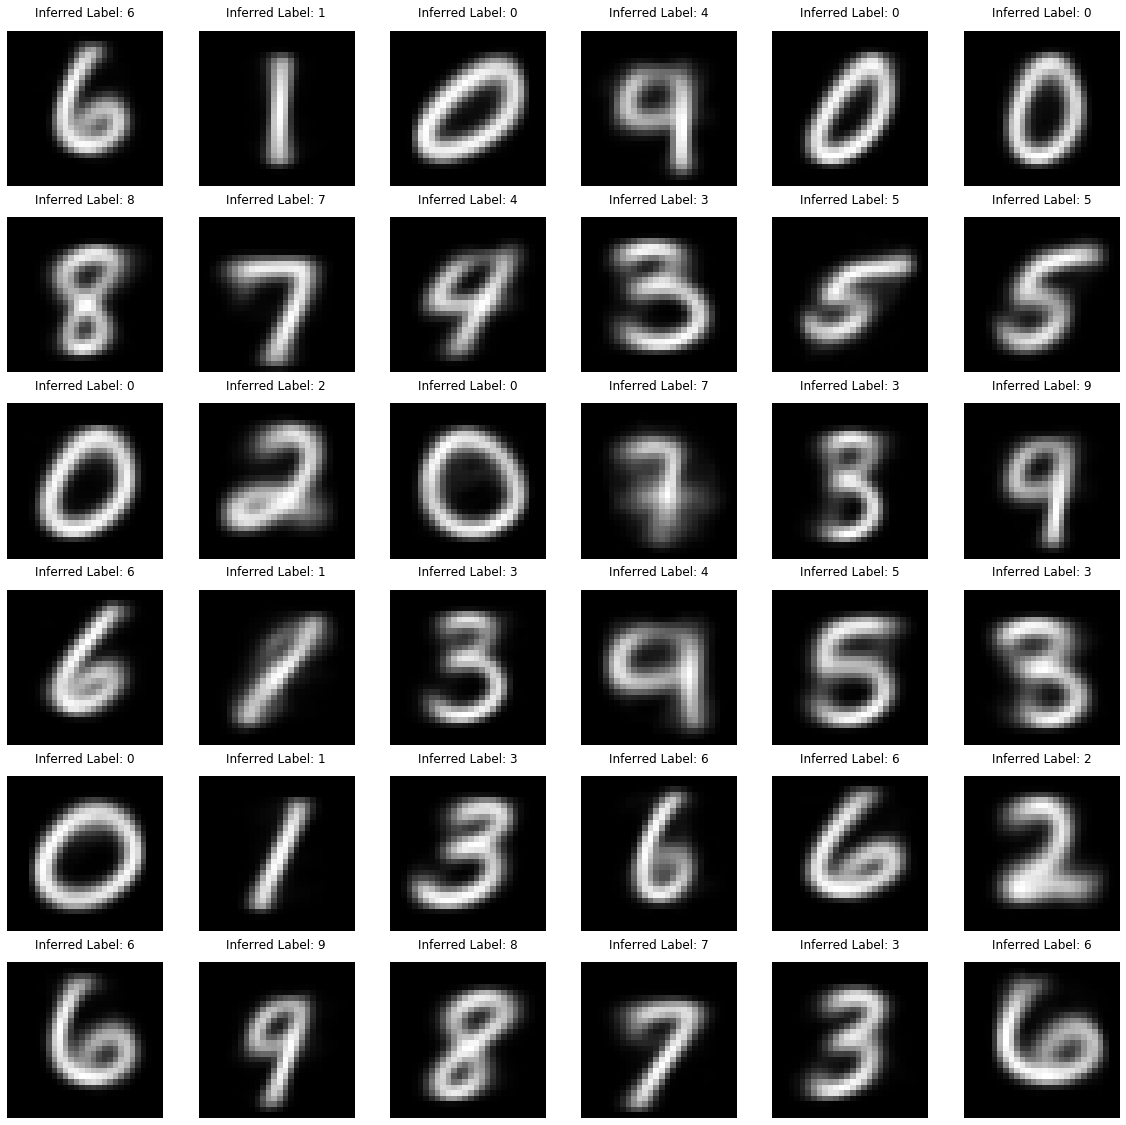

In [63]:
# Creating visualizations
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

for i, ax in enumerate(axs.flat):
    
    # Get actual label
    for key, val in cluster_labels.items():
        if i in val:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # Adding image
    ax.matshow(images[i])
    ax.axis('off')
    
fig.show()